In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

from memory.agent import HandcraftedAgent
from memory.environment import RoomEnv

In [2]:
from tqdm.notebook import tqdm
import numpy as np

env_params = {
    "semantic_knowledge_path": "./data/semantic-knowledge-small.json",
    "names_path": "./data/top-human-names-small",
    "weighting_mode": "highest",
    "probs": {
        "commonsense": 0.7,
        "new_location": 0.1,
        "new_object": 0.1,
        "switch_person": 0.5,
    },
    "limits": {
        "heads": None,
        "tails": None,
        "names": None,
        "allow_spaces": False,
    },
    "max_step": 1000,
    "disjoint_entities": True,
    "num_agents": 1,
}


results_all = {}
seeds = [0, 1, 2, 3, 4]
caps = [16, 32]
num_agentss = [1, 2]
agent_types = [
    "episodic",
    "semantic",
    "episodic_semantic",
    "episodic_semantic_pretrain",
]

for agent_type in tqdm(agent_types):
    results_all[agent_type] = {}
    strategy_types = []
    if agent_type == "episodic":
        for forget_policy in ["oldest", "random"]:
            for answer_policy in ["latest", "random"]:
                strategy_types.append(f"{forget_policy}_{answer_policy}")

    elif agent_type == "semantic":
        for forget_policy in ["weakest", "random"]:
            for answer_policy in ["strongest", "random"]:
                strategy_types.append(f"{forget_policy}_{answer_policy}")
    elif agent_type == "episodic_semantic":
        for forget_policy in ["generalize", "random"]:
            for answer_policy in ["episem", "random"]:
                strategy_types.append(f"{forget_policy}_{answer_policy}")
    else:
        for forget_policy in ["oldest", "random"]:
            for answer_policy in ["episem", "random"]:
                strategy_types.append(f"{forget_policy}_{answer_policy}")

    for capacity in caps:
        results_all[agent_type][capacity] = {}
        for strategy_type in strategy_types:
            results_all[agent_type][capacity][strategy_type] = {}
            for num_agents in num_agentss:
                stats = []
                for seed in seeds:

                    forget_policy, answer_policy = strategy_type.split("_")
                    if agent_type == "episodic":
                        episodic_capacity = capacity
                        semantic_capacity = 0
                    elif agent_type == "semantic":
                        episodic_capacity = 0
                        semantic_capacity = capacity
                    else:
                        episodic_capacity = capacity // 2
                        semantic_capacity = capacity // 2

                    env_params["num_agents"] = num_agents
                    env = RoomEnv(**env_params)
                    agent = HandcraftedAgent(
                        seed=seed,
                        agent_type=agent_type,
                        forget_policy=forget_policy,
                        answer_policy=answer_policy,
                        episodic_capacity=episodic_capacity,
                        semantic_capacity=semantic_capacity,
                        env=env,
                    )
                    agent.run()
                    stats.append(agent.rewards)
                results_all[agent_type][capacity][strategy_type][num_agents] = {
                    "mean": round(np.mean(stats).item(), 4),
                    "std": round(np.std(stats).item(), 4),
                }

  0%|          | 0/4 [00:00<?, ?it/s]

episodic [602.8]
semantic [525.4]
episodic_semantic [624.6]
episodic_semantic_pretrain [728.6]
episodic [489.4]
semantic [518.4]
episodic_semantic [611.4]
episodic_semantic_pretrain [692.2]


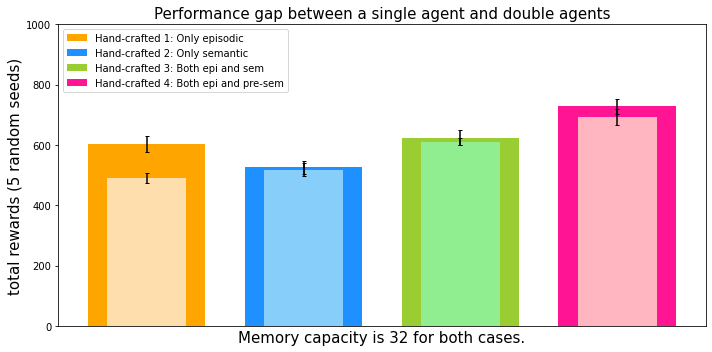

In [4]:
import matplotlib.pyplot as plt

caps = {1: [32], 2: [16]}

fig, ax = plt.subplots(figsize=(10, 5))
color_order = {
    1: ["navajowhite", "lightskyblue", "lightgreen", "lightpink"],
    2: ["orange", "dodgerblue", "yellowgreen", "deeppink"],
}
width = {1: 0.1, 2: 0.15}

legend_order = [
    "Hand-crafted 1: Only episodic",
    "Hand-crafted 2: Only semantic",
    "Hand-crafted 3: Both epi and sem",
    "Hand-crafted 4: Both epi and pre-sem",
]
for num_agents in num_agentss[::-1]:
    idx = np.asanyarray([i for i in range(len(caps[num_agents]))])

    for agent_type, w, color in zip(
        agent_types, [-1.5, -0.5, 0.5, 1.5], color_order[num_agents]
    ):
        if agent_type == "episodic":
            strategy_type = "oldest_latest"
        elif agent_type == "semantic":
            strategy_type = "weakest_strongest"
        elif agent_type == "episodic_semantic":
            strategy_type = "generalize_episem"
        else:
            strategy_type = "oldest_episem"

        means = [
            results_all[agent_type][capacity][strategy_type][num_agents]["mean"]
            for capacity in caps[num_agents]
        ]
        stds = [
            results_all[agent_type][capacity][strategy_type][num_agents]["std"]
            for capacity in caps[num_agents]
        ]

        print(agent_type, means)
        ax.bar(
            x=idx + w * 0.2,
            height=means,
            yerr=stds,
            width=width[num_agents],
            color=color,
            capsize=2,
        )
        ax.set_xticks([])
        # ax.set_xticklabels(caps[num_agents])
        ax.legend(legend_order, fontsize=10, loc="upper left")
        ax.set_xlabel("Memory capacity is 32 for both cases.", fontsize=15)
        ax.set_ylabel(f"total rewards ({len(seeds)} random seeds)", fontsize=15)

        ax.set_ylim([0, env_params["max_step"]])

        fig.tight_layout()
        plt.title(
            f"Performance gap between a single agent and double agents",
            fontsize=15,
        )
        plt.savefig(f"./figures/single-and-double-agents.pdf", bbox_inches="tight")
        # plt.show()